In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from sklearn.model_selection import train_test_split

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [207]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('../DXG Historical Data.csv')

In [208]:
# convert date field from string to Date format and make it index
def tranformData(df: pd.DataFrame):
  df['Date'] = pd.to_datetime(df.Date, format='%m/%d/%Y')
  df['Price'] = df['Price'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Open'] = df['Open'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['High'] = df['High'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Low'] = df['Low'].astype(str).apply(lambda x: float(x.replace(',', '')))
  def convert_to_number(x):
      if 'M' in x:
          return float(x.replace('M', '')) * 1000000
      elif 'K' in x:
          return float(x.replace('K', '')) * 1000
      else:
          return float(x)
  df['Vol.'] = df['Vol.'].apply(convert_to_number)
  df['Change %'] = df['Change %'].apply(lambda x: float(x.strip('%'))/100)

In [209]:
tranformData(df)

In [210]:
#Định dạng lại cột Date từ obj -> datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
# Chuyển cột Date làm index để lập biểu đồ so sánh về sau
df.index = df.Date
df.drop('Date', axis=1, inplace=True)

In [211]:
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2017-12-01,12251.8,11949.3,12403.1,11919.0,8610000.0,0.0279
2017-12-04,12705.6,12463.6,12705.6,12282.1,9420000.0,0.0370
2017-12-05,12282.1,12705.6,12917.3,12282.1,11060000.0,-0.0333
2017-12-06,12161.1,12161.1,12342.6,11919.0,7720000.0,-0.0099
2017-12-07,12100.6,12161.1,12312.3,11858.5,5230000.0,-0.0050
...,...,...,...,...,...,...
2023-05-29,14600.0,14650.0,14750.0,14500.0,13240000.0,0.0104
2023-05-30,14950.0,14950.0,15200.0,14750.0,30200000.0,0.0240
2023-05-31,14900.0,14950.0,15200.0,14850.0,15100000.0,-0.0033


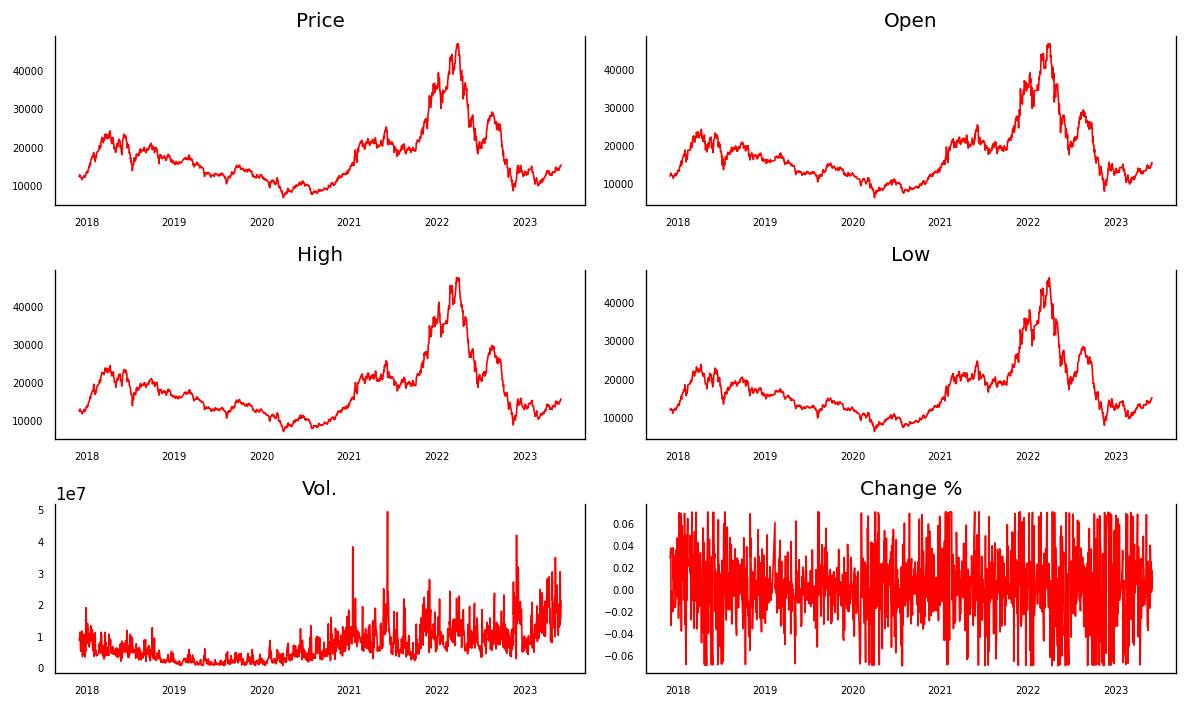

In [212]:


# Plot
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();
     

In [213]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)  

,Price_x,Open_x,High_x,Low_x,Vol._x,Change %_x
Price_y,1.0000,0.0002,0.0311,0.0128,0.0831,0.0015
Open_y,0.0000,1.0000,0.0000,0.0000,0.0100,0.0000
High_y,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
Low_y,0.0000,0.0000,0.0000,1.0000,0.0001,0.0000
Vol._y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0623
Change %_y,0.0747,0.0302,0.1042,0.0557,0.0472,1.0000


In [214]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Price  ::  716.44    > 83.9383   =>   True
Open   ::  465.11    > 60.0627   =>   True
High   ::  244.72    > 40.1749   =>   True
Low    ::  91.55     > 24.2761   =>   True
Vol.   ::  27.65     > 12.3212   =>   True
Change % ::  0.41      > 4.1296    =>   False


In [215]:
nobs=int(0.2*len(df))
n_train = int(0.7 * len(df))
n_test = int(0.2 * len(df))
n_validation = len(df) - n_train - n_test
nobs_val= n_validation
df_train = df[:n_train]
df_test = df[n_train:n_train+n_test]
df_validation = df[n_train+n_test:]

# Kiểm tra kích thước
print(df_train.shape)
print(df_test.shape)
print(df_validation.shape)

(959, 6)
(274, 6)
(138, 6)


In [216]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [217]:
# ADF Test on each column
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.4765
 No. Lags Chosen       = 4
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.5451. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.8303
 No. Lags Chosen       = 22
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.3655. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit 

In [218]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [219]:
# ADF Test trên từng cột của DataFrame chứa sự khác biệt đầu tiên
for name in df_differenced.columns:
    adfuller_test(df_differenced[name], name=name)
    print('\n')


    Augmented Dickey-Fuller Test on "Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -17.024
 No. Lags Chosen       = 3
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.8496
 No. Lags Chosen       = 22
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.0

In [220]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [221]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.0689
 No. Lags Chosen       = 20
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.6669
 No. Lags Chosen       = 20
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 

In [222]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  69.14096125237752
BIC :  69.35459706027308
FPE :  1.0654636248155251e+30
HQIC:  69.22233488070741 

Lag Order = 2
AIC :  67.52568008284334
BIC :  67.92276226562606
FPE :  2.118530052814585e+29
HQIC:  67.67693586592009 

Lag Order = 3
AIC :  66.56823128373817
BIC :  67.14906530737035
FPE :  8.13259683613752e+28
HQIC:  66.78949266060836 

Lag Order = 4
AIC :  65.9456844205759
BIC :  66.7105765879926
FPE :  4.3639344936329534e+28
HQIC:  66.23707517723965 

Lag Order = 5
AIC :  65.53325848850983
BIC :  66.48251594278629
FPE :  2.8892995008847525e+28
HQIC:  65.89490275925235 

Lag Order = 6
AIC :  65.21235432066433
BIC :  66.3462850481986
FPE :  2.0963704724949935e+28
HQIC:  65.6443765893939 

Lag Order = 7
AIC :  64.98442668494359
BIC :  66.30333951865454
FPE :  1.6693185177719394e+28
HQIC:  65.48695178653603 

Lag Order = 8
AIC :  64.81897758948308
BIC :  66.323182212024
FPE :  1.4150239900763472e+28
HQIC:  65.39213071113285 

Lag Order = 9
AIC :  64.70982545109061
BI

In [223]:
x = model.select_order(maxlags=20)
x.summary()

,AIC,BIC,FPE,HQIC
0,73.80,73.84,1.129e+32,73.82
1,69.18,69.40,1.111e+30,69.27
2,67.56,67.96,2.194e+29,67.71
3,66.59,67.18,8.350e+28,66.82
4,65.96,66.74,4.437e+28,66.26
5,65.55,66.51,2.937e+28,65.92
6,65.24,66.38,2.148e+28,65.67
7,65.01,66.34*,1.706e+28,65.51
8,64.85,66.36,1.453e+28,65.42
9,64.73,66.44,1.296e+28,65.38


In [246]:
model_fitted = model.fit(19)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 17, Jun, 2023
Time:                     00:21:28
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    67.5773
Nobs:                     938.000    HQIC:                   65.3726
Log likelihood:          -37318.4    FPE:                6.37123e+27
AIC:                      64.0142    Det(Omega_mle):     3.18324e+27
--------------------------------------------------------------------
Results for equation Price
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -0.352797        14.875271           -0.024           0.981
L1.Price            -0.925985         0.132760           -6.975           0.000
L1.Open             -0.084878         0.095404           -0.890 

In [247]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

19


array([[-1.02e+03, -3.70e+02, -4.22e+02, -5.30e+02, -5.00e+05, -8.24e-02],
       [ 4.00e+02, -7.00e+02, -3.50e+02,  1.00e+02,  1.67e+06,  7.28e-02],
       [-6.00e+02,  5.00e+02,  0.00e+00, -6.50e+02,  8.70e+05, -5.15e-02],
       [ 8.50e+02, -6.00e+02,  5.00e+01,  4.50e+02, -3.62e+06,  7.60e-02],
       [-2.50e+02,  1.30e+03,  6.50e+02,  5.50e+02,  2.83e+06, -5.82e-02],
       [ 6.00e+02, -1.15e+03, -3.00e+02, -3.50e+02,  1.02e+06,  4.56e-02],
       [-6.00e+02,  1.15e+03,  3.00e+02,  3.50e+02, -1.39e+06, -6.41e-02],
       [-1.00e+02, -1.60e+03, -9.50e+02, -1.00e+03,  9.20e+05,  2.68e-02],
       [ 4.50e+02,  1.45e+03,  1.15e+03,  1.00e+03, -8.40e+05,  2.87e-02],
       [ 1.50e+02,  2.50e+02,  2.50e+02,  3.50e+02,  3.37e+06, -1.59e-02],
       [-6.00e+02, -6.00e+02, -1.30e+03, -6.50e+02, -8.39e+06, -3.85e-02],
       [-5.00e+02, -4.50e+02,  4.00e+02, -5.50e+02,  6.00e+06,  5.40e-03],
       [ 8.50e+02, -4.00e+02, -5.00e+02,  1.00e+02, -4.20e+05,  6.91e-02],
       [-3.50e+02,  9.00e

In [248]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[n_train:n_train+n_test], columns=df.columns + '_2d')
df_forecast

,Price_2d,Open_2d,High_2d,Low_2d,Vol._2d,Change %_2d
Date,,,,,,
2021-10-07,-1070.338653,673.161878,-519.671194,102.442487,-7.415065e+06,-9.897164e-02
2021-10-08,264.248608,-1338.332929,-257.851700,-748.622458,5.213303e+06,7.319785e-02
2021-10-11,163.672985,724.294399,147.143222,474.844685,-1.541272e+06,-5.623482e-03
2021-10-12,-132.605295,333.465826,183.105875,169.948975,-1.721378e+06,-1.399780e-02
2021-10-13,279.232393,-646.336301,-235.228669,-190.365238,-1.036598e+06,2.146148e-02
...,...,...,...,...,...,...
2022-11-03,-0.057168,-0.057638,-0.066508,-0.059450,-4.105612e+02,-7.749181e-07
2022-11-04,-0.057130,-0.057782,-0.066485,-0.059546,-4.106511e+02,-7.684992e-07
2022-11-07,-0.057129,-0.057692,-0.066515,-0.059477,-4.108781e+02,-7.708882e-07


In [249]:
# Forecast val
fc_val = model_fitted.forecast(y=forecast_input, steps=nobs_val)
df_forecast_val = pd.DataFrame(fc_val, index=df.index[n_train+n_test:], columns=df.columns + '_2d')
df_forecast_val

,Price_2d,Open_2d,High_2d,Low_2d,Vol._2d,Change %_2d
Date,,,,,,
2022-11-10,-1070.338653,673.161878,-519.671194,102.442487,-7.415065e+06,-9.897164e-02
2022-11-11,264.248608,-1338.332929,-257.851700,-748.622458,5.213303e+06,7.319785e-02
2022-11-14,163.672985,724.294399,147.143222,474.844685,-1.541272e+06,-5.623482e-03
2022-11-15,-132.605295,333.465826,183.105875,169.948975,-1.721378e+06,-1.399780e-02
2022-11-16,279.232393,-646.336301,-235.228669,-190.365238,-1.036598e+06,2.146148e-02
...,...,...,...,...,...,...
2023-05-29,-0.062483,-0.001869,0.036935,-0.047635,4.231331e+02,-2.629617e-06
2023-05-30,-0.011042,-0.050727,-0.097301,-0.045582,-1.126413e+03,2.043180e-07
2023-05-31,-0.211894,0.003271,-0.091179,-0.071001,2.883407e+02,-1.146921e-05


In [250]:
def invert_transformation(df_train, df_forecast_val, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc_val = df_forecast_val.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc_val[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc_val[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc_val[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc_val[str(col)+'_1d'].cumsum()
    return df_fc_val

In [251]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [252]:
df_results_val = invert_transformation(df_train, df_forecast_val, second_diff=True)        
df_results_val.loc[:, ['Price_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Vol._forecast', 'Change %_forecast']]

,Price_forecast,Open_forecast,High_forecast,Low_forecast,Vol._forecast,Change %_forecast
Date,,,,,,
2022-11-10,19429.661347,19673.161878,19830.328806,19302.442487,3.674935e+06,-0.019972
2022-11-11,19373.571303,19007.990828,19652.805911,18856.262516,5.693173e+06,-0.006245
2022-11-14,19481.154244,19067.114176,19622.426239,18884.927230,6.170140e+06,0.001857
2022-11-15,19456.131889,19459.703350,19775.152441,19083.540919,4.925728e+06,-0.004038
2022-11-16,19710.341926,19205.956223,19692.649975,19091.789370,2.644719e+06,0.011529
...,...,...,...,...,...,...
2023-05-29,24267.992438,22617.306211,23243.278022,22289.700453,7.363933e+06,-0.031203
2023-05-30,24300.492251,22638.793485,23266.053310,22310.247990,7.361129e+06,-0.031493
2023-05-31,24332.780170,22660.284030,23288.737419,22330.724525,7.358613e+06,-0.031794


In [253]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['Price_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Vol._forecast', 'Change %_forecast']]

,Price_forecast,Open_forecast,High_forecast,Low_forecast,Vol._forecast,Change %_forecast
Date,,,,,,
2021-10-07,19429.661347,19673.161878,19830.328806,19302.442487,3.674935e+06,-0.019972
2021-10-08,19373.571303,19007.990828,19652.805911,18856.262516,5.693173e+06,-0.006245
2021-10-11,19481.154244,19067.114176,19622.426239,18884.927230,6.170140e+06,0.001857
2021-10-12,19456.131889,19459.703350,19775.152441,19083.540919,4.925728e+06,-0.004038
2021-10-13,19710.341926,19205.956223,19692.649975,19091.789370,2.644719e+06,0.011529
...,...,...,...,...,...,...
2022-11-03,28156.141924,25007.739554,25728.480875,24535.478079,3.263503e+06,-0.077982
2022-11-04,28180.817338,25021.362270,25742.199459,24547.915252,3.205225e+06,-0.078378
2022-11-07,28205.435623,25034.927294,25755.851529,24560.292948,3.146535e+06,-0.078776


In [254]:
# Chuyển đổi dự đoán về đơn vị ban đầu
df_future = pd.DataFrame(fc, columns=[col + '_2d' for col in df.columns])

def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to the original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col) + '_1d'] = (df_train[col].iloc[-1] - df_train[col].iloc[-2]) + df_fc[col + '_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col) + '_forecast'] = df_train[col].iloc[-1] + df_fc[col + '_1d'].cumsum()
    return df_fc

df_future_results = invert_transformation(df_train, df_future, second_diff=True)
df_future_results.loc[:, ['Price_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Vol._forecast', 'Change %_forecast']]


,Price_forecast,Open_forecast,High_forecast,Low_forecast,Vol._forecast,Change %_forecast
0,19429.661347,19673.161878,19830.328806,19302.442487,3.674935e+06,-0.019972
1,19373.571303,19007.990828,19652.805911,18856.262516,5.693173e+06,-0.006245
2,19481.154244,19067.114176,19622.426239,18884.927230,6.170140e+06,0.001857
3,19456.131889,19459.703350,19775.152441,19083.540919,4.925728e+06,-0.004038
4,19710.341926,19205.956223,19692.649975,19091.789370,2.644719e+06,0.011529
...,...,...,...,...,...,...
269,28156.141924,25007.739554,25728.480875,24535.478079,3.263503e+06,-0.077982
270,28180.817338,25021.362270,25742.199459,24547.915252,3.205225e+06,-0.078378
271,28205.435623,25034.927294,25755.851529,24560.292948,3.146535e+06,-0.078776
272,28229.996755,25048.434590,25769.437115,24572.611133,3.087435e+06,-0.079174


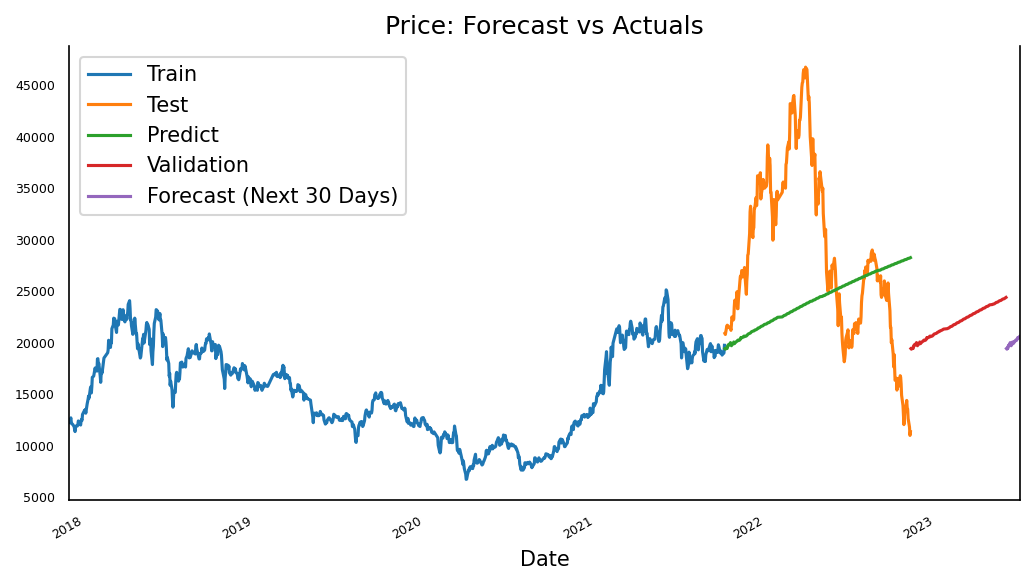

In [255]:
import datetime

# Sử dụng model_fitted để dự đoán 30 ngày tiếp theo
n_forecast_days = 30
fc = model_fitted.forecast(y=forecast_input, steps=n_forecast_days)

# Chuyển đổi dự đoán thành DataFrame
df_future = pd.DataFrame(fc, columns=[col + '_2d' for col in df.columns])

# Chuyển đổi dự đoán về đơn vị ban đầu
df_future_results = invert_transformation(df_train, df_future, second_diff=True)

# Tạo index cho 30 ngày tiếp theo
future_dates = pd.date_range(start=df.index[-1] + datetime.timedelta(days=1), periods=n_forecast_days, freq='D')

# Tạo DataFrame chứa dự đoán cho 30 ngày tiếp theo
df_future_forecast = pd.DataFrame(df_future_results.values, index=future_dates, columns=df_future_results.columns)

# Vẽ đồ thị
fig, ax = plt.subplots(dpi=150, figsize=(7, 4))

# Chọn cột dữ liệu cần vẽ
col = 'Price'

# Vẽ dữ liệu huấn luyện
df_train[col].plot(legend=True, ax=ax, label='Train')

# Vẽ dữ liệu kiểm tra
df_test[col][-nobs:].plot(legend=True, ax=ax, label='Test')

# Vẽ dự đoán trên tập huấn luyện
df_results[col+'_forecast'].plot(legend=True, ax=ax, label='Predict').autoscale(axis='x', tight=True)

# Vẽ dự đoán trên tập kiểm tra
df_results_val[col+'_forecast'].plot(legend=True, ax=ax, label='Validation').autoscale(axis='x', tight=True)

# Vẽ dự đoán cho 30 ngày tiếp theo
df_future_forecast[col + '_forecast'].plot(legend=True, ax=ax, label='Forecast (Next 30 Days)')

# Định dạng đồ thị và tiêu đề
ax.set_title(col + ": Forecast vs Actuals")
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.spines["top"].set_alpha(0)
ax.tick_params(labelsize=6)

plt.tight_layout()


In [256]:
def forecast_accuracy(forecast, actual):
    forecast = np.array(forecast)  # Chuyển đổi dự đoán thành numpy array
    actual = np.array(actual)  # Chuyển đổi dữ liệu thực tế thành numpy array
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return {'mape': mape, 'rmse': rmse, }


print('Forecast Accuracy of: Price')
accuracy_prod = forecast_accuracy(df_results['Price_forecast'].values, df_test['Price'])
for k, v in accuracy_prod.items():
    print(str.title(k), ': ', round(v, 4))



Forecast Accuracy of: Price
Mape :  0.3147
Rmse :  10740.6609
